Mean Absolute Percentage Error (MAPE) für das Lasso Regression Modell: 11.33%
Mean Absolute Percentage Error (MAPE) für das Basismodell: 12.63%
Bias des Modells: -684.72


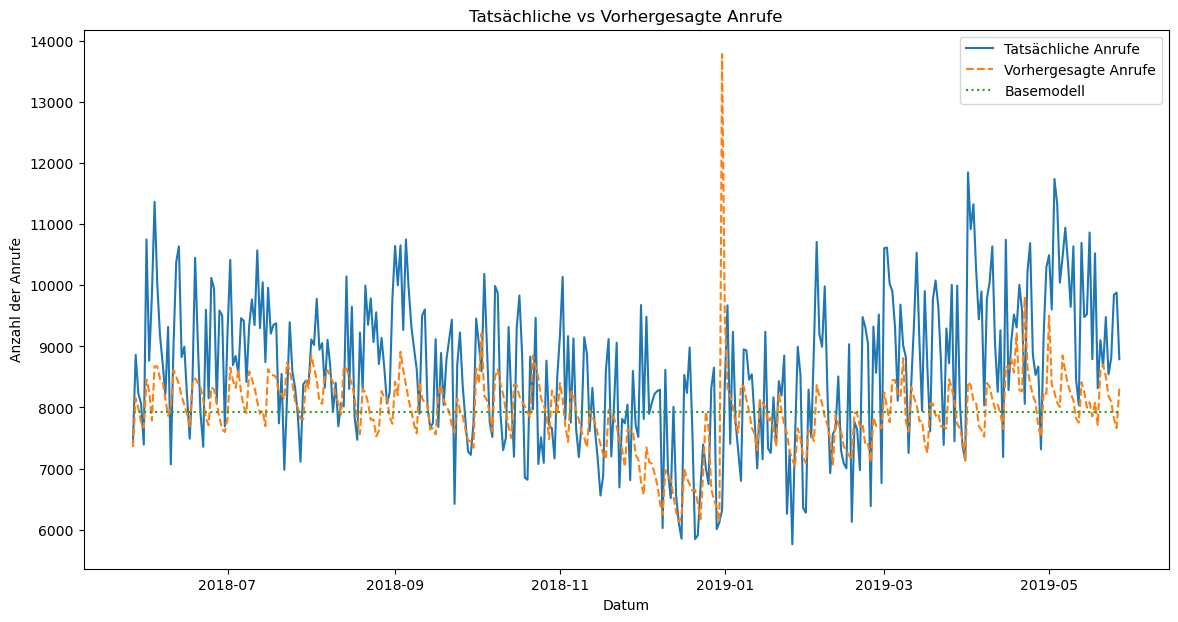

In [57]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Laden der Daten
df = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/processed_data.csv')
train = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/train_data.csv')
test = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/test_data.csv')

# Konvertieren der 'date'-Spalte in datetime-Objekte ohne Uhrzeit
df['date'] = pd.to_datetime(df['date']).dt.date
train['date'] = pd.to_datetime(train['date']).dt.date
test['date'] = pd.to_datetime(test['date']).dt.date

# Definieren der Features
#required_features = ['weekday', 'schulferien', 'calendarweek', 'month', 'season', 'year', 'Feiertage', 'lag_49_calls', 'lag_365_calls', 'average7days45lag_calls']
required_features = ['weekday', 'schulferien', 'calendarweek', 'month', 'season', 'Feiertage', 'lag_49_calls', 'lag_365_calls', 'average7days45lag_calls']

# Überprüfen, welche Features im Training und im Test-Datenrahmen vorhanden sind
available_features = [feature for feature in required_features if feature in train.columns]

if len(available_features) < len(required_features):
    missing_features = set(required_features) - set(available_features)
    print(f"Folgende Features fehlen in den Trainingsdaten und werden ignoriert: {missing_features}")

# Training des Lasso-Modells
X_train = train[available_features]
y_train = train['calls']
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

# Funktion zur Vorhersage für den Zeitraum im Test-DataFrame
def predict_for_test_period(model, test_df, date_col='date', feature_cols=available_features):
    predictions = []
    prediction_dates = []
    
    # Vorhersage für den gesamten Zeitraum im Test-DataFrame
    start_date = test_df[date_col].min()
    end_date = test_df[date_col].max()
    future_dates = pd.date_range(start=start_date, end=end_date, freq='D').date

    # Erstellen eines DataFrames für zukünftige Daten
    future_df = pd.DataFrame({'date': future_dates})
    
    # Zusammenführen mit dem Test-Datenrahmen für die erforderlichen Features
    future_df = future_df.merge(test_df[['date'] + [feature for feature in feature_cols if feature in test_df.columns]],
                                how='left', 
                                left_on='date', 
                                right_on='date')
    
    # Fallback-Werte für NaN in den Lag-Features
    future_df.fillna({'lag_49_calls': 0, 'lag_365_calls': 0, 'average7days45lag_calls': 0}, inplace=True)
    
    # Vorhersagen für die zukünftigen Daten erstellen
    future_X = future_df[feature_cols]
    future_pred = model.predict(future_X)
    
    predictions.extend(future_pred)
    prediction_dates.extend(future_dates)
    
    return predictions, prediction_dates

# Vorhersagen generieren
predictions, prediction_dates = predict_for_test_period(lasso_model, test)

# Überprüfen, ob Vorhersagen generiert wurden
if predictions and prediction_dates:
    # Ergebnisse in einem DataFrame zusammenfassen
    prediction_df = pd.DataFrame({
        'date': prediction_dates,
        'Lasso Regression': predictions
    })

    # Konvertiere die 'date'-Spalte in beiden DataFrames in datetime64[ns]
    prediction_df['date'] = pd.to_datetime(prediction_df['date'])
    test['date'] = pd.to_datetime(test['date'])    

    prediction_df.to_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/prediction_callsLRwFlag.csv', index=False)
    
    # Zusammenführen mit tatsächlichen Werten
    merged_df = pd.merge(test, prediction_df, on='date', how='right')

    # Füge die Basemodell-Spalte hinzu und fülle sie mit 9500
    merged_df['Basemodell'] = 7919.5

    # Berechnung des MAPE für das Lasso Modell
    merged_df.dropna(subset=['calls'], inplace=True)  # Entfernen von Zeilen ohne tatsächliche Anrufe
    mape_lasso = np.mean(np.abs((merged_df['calls'] - merged_df['Lasso Regression']) / merged_df['calls'])) * 100
    print(f'Mean Absolute Percentage Error (MAPE) für das Lasso Regression Modell: {mape_lasso:.2f}%')

    # Berechnung des MAPE für das Basismodell
    mape_base = np.mean(np.abs((merged_df['calls'] - merged_df['Basemodell']) / merged_df['calls'])) * 100
    print(f'Mean Absolute Percentage Error (MAPE) für das Basismodell: {mape_base:.2f}%')

    # Berechnung des Bias
    bias =  np.mean((merged_df['Lasso Regression'] - merged_df['calls']))
    print(f'Bias des Modells: {bias:.2f}')
    
    # Plotten der tatsächlichen Werte und Vorhersagen
    plt.figure(figsize=(14, 7))
    plt.plot(merged_df['date'], merged_df['calls'], label='Tatsächliche Anrufe')
    plt.plot(merged_df['date'], merged_df['Lasso Regression'], label='Vorhergesagte Anrufe', linestyle='--')
    plt.plot(merged_df['date'], merged_df['Basemodell'], label='Basemodell', linestyle=':')
    plt.xlabel('Datum')
    plt.ylabel('Anzahl der Anrufe')
    plt.title('Tatsächliche vs Vorhergesagte Anrufe')
    plt.legend()
    plt.show()
else:
    print("Es wurden keine Vorhersagen generiert. Überprüfen Sie die Daten und die Filterbedingungen.")
